In [1]:
import os
import numpy as np
import time
import copy
import sys

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [2]:
folder = "/home/kristjan/local_work/morbs_test/c2h2/"
file_basis_set = folder + "BR"
file_xyz = folder + "p.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "out"

In [3]:
emin = -20.0
emax =  20.0

In [4]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Read cp2k out: %.3f" % (time.time()-time1))

time1 = time.time()
at_positions, at_elems = cu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

time1 = time.time()
morb_composition, morb_energies, morb_occs, ref_en, i_homo = cu.load_restart_wfn_file(file_restart, emin, emax, fermi)
print("Found %d orbitals" % len(morb_energies))
print("Read restart: %.3f" % (time.time()-time1))

Read cp2k input: 0.007
Read cp2k out: 0.003
Read xyz: 0.005
Read basis sets: 0.005
First molecular index in energy range:  0
Found 10 orbitals
Read restart: 0.005


In [6]:
# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.08 # Good to choose a factor of the lattice parameter 4.26
step *= ang_2_bohr
cell_n = (np.round(cell/step)).astype(int)

# !!! NB: Redefine cell such that step stays the same (and a factor of lattice param)
#cell = cell_n*step

#cu.center_atoms_to_cell(at_positions, cell)

In [21]:
cell

array([ 15.117809  ,  15.117809  ,  28.34589188])

In [56]:
# define evaluation region:

x_eval_region = None
y_eval_region = None
z_eval_region = None

eval_regions = [x_eval_region, y_eval_region, z_eval_region]

origin = np.zeros(3)
new_cell = np.copy(cell)

for i, e_reg in enumerate(eval_regions):
    if e_reg is None:
        origin[i] = 0.0
        new_cell[i] = cell[i]
    else:
        origin[i] = e_reg[0]
        new_cell[i] = e_reg[1] - e_reg[0]


In [57]:
morb_grids_new = cu.calc_morbs_in_3D_region(cell, cell_n,
                                            at_positions, at_elems,
                                            basis_sets, morb_composition,
                                            x_eval_region = x_eval_region,
                                            y_eval_region = y_eval_region,
                                            z_eval_region = z_eval_region,
                                            eval_cutoff = 16.0
                                           )

Global cell:    [100 100 188]
Eval cell:    [100 100 188]
local cell:  [200 200 201]
---- Setup: 0.1364
---- Radial calc time : 17.026889
---- Spherical calc time : 1.719990
---- Loc -> loc_morb time : 9.987110
---- loc_morb -> glob time : 2.024281
---- Total time: 31.8851


In [58]:
morb_grids_new.shape

(10, 100, 100, 188)

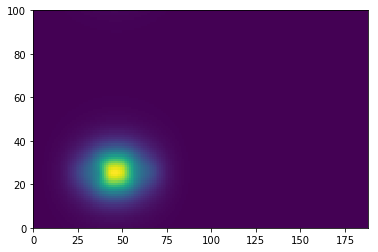

In [63]:
plt.pcolormesh(morb_grids_new[0][20, :, :])
plt.show()

In [64]:
cu.write_cube_file("/home/kristjan/local_work/morbs_test/c2h2/my_cubes/test.cube",
                   file_xyz, new_cell, morb_grids_new[0].shape, morb_grids_new[0], origin = origin)

In [65]:
# check for normalization
dv = cell/cell_n
vol_elem = dv[0]*dv[1]*dv[2]
np.sum(morb_grids_new[0]**2)*vol_elem

1.0000000023678439